In [2]:
import pandas as pd 
import numpy as np
import os
import re
import emoji
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

#Count vectorizer for N grams
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# Nltk for tekenize and stopwords
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 


# train_data = pd.read_csv('../input/covid19-tweet-classification/train.csv')
# test_data = pd.read_csv('../input/covid19-tweet-classification/test.csv')
train_data = pd.read_csv('../input/covid19tweetclassificationupdated/updated_train.csv')
test_data = pd.read_csv('../input/covid19tweetclassificationupdated/updated_test.csv')

# EDA

In [3]:
print(f'training sizes: {train_data.shape}')
print(f'test sizes: {test_data.shape}')

training sizes: (5287, 3)
test sizes: (1962, 2)


In [4]:
def missing_value_of_data(data):
    total=data.isnull().sum().sort_values(ascending=False)
    percentage=round(total/data.shape[0]*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])

In [5]:
missing_value_of_data(train_data)

,Total,Percentage
target,0,0.0
text,0,0.0
ID,0,0.0


In [6]:
missing_value_of_data(test_data)

,Total,Percentage
text,0,0.0
ID,0,0.0


In [7]:
#n_grams
def ngrams_top(corpus,ngram_range,n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english',ngram_range=ngram_range).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    total_list=words_freq[:n]
    df=pd.DataFrame(total_list,columns=['text','count'])
    return df

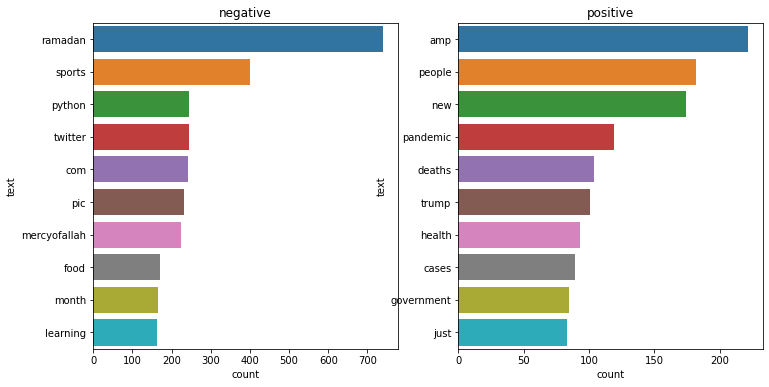

In [8]:
neg_unigrams = ngrams_top(train_data.text[train_data.target == 0],(1,1),n=10)
pos_unigrams = ngrams_top(train_data.text[train_data.target == 1],(1,1),n=10)

fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].set_title('negative')
axs[1].set_title('positive')

sns.barplot(x='count', y='text', data=neg_unigrams, ax=axs[0])
sns.barplot(x='count', y='text', data=pos_unigrams, ax=axs[1]);

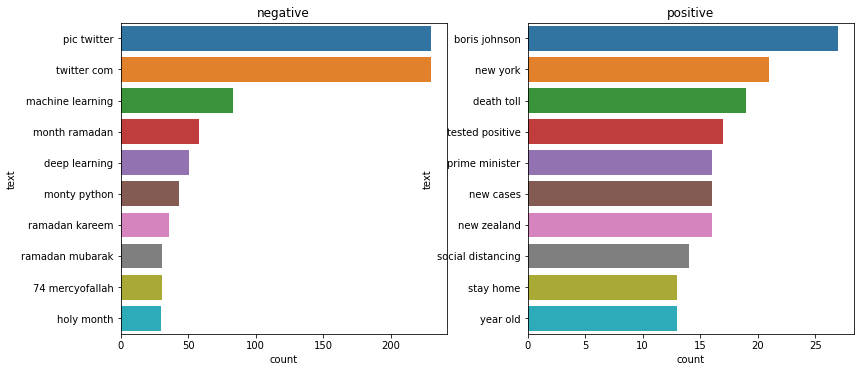

In [9]:
neg_bigrams = ngrams_top(train_data.text[train_data.target == 0],(2,2),n=10)
pos_bigrams = ngrams_top(train_data.text[train_data.target == 1],(2,2),n=10)


fig, axs = plt.subplots(1, 2, figsize=(12,6))
fig.tight_layout(pad=5.0)


axs[0].set_title('negative')
axs[1].set_title('positive')

sns.barplot(x='count', y='text', data=neg_bigrams, ax=axs[0])
sns.barplot(x='count', y='text', data=pos_bigrams, ax=axs[1]);

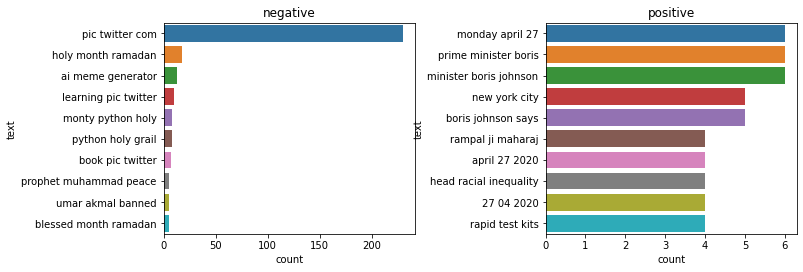

In [10]:
neg_trigrams = ngrams_top(train_data.text[train_data.target == 0],(3,3),n=10)
pos_trigrams = ngrams_top(train_data.text[train_data.target == 1],(3,3),n=10)


fig, axs = plt.subplots(1, 2, figsize=(12,6))
fig.tight_layout(pad=10.0)


axs[0].set_title('negative')
axs[1].set_title('positive')

sns.barplot(x='count', y='text', data=neg_trigrams, ax=axs[0])
sns.barplot(x='count', y='text', data=pos_trigrams, ax=axs[1]);

In [11]:
def rep(text):
    """
    replace repated chars: hiiiiii! -> hi!
    """
    grp = text.group(0)
    if len(grp) > 1:
        return grp[0:1] 
    return grp
   
def unique_char(rep,sentence):
    convert = re.sub(r'(\w)\1+', rep, sentence) 
    return convert

In [12]:
train_data['text'] = train_data['text'].apply(lambda x : unique_char(rep,x))
test_data['text'] = test_data['text'].apply(lambda x : unique_char(rep,x))

# Define Model 

In [13]:
#config
import transformers
import torch

class config:
    MAX_LEN = 320
    DEVICE = torch.device("cuda")
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 16
    EPOCHS = 4
    BERT_PATH = "../input/bert-base-uncased/"
    MODEL_PATH = "pytorch_model.bin"
    TRAINING_FILE = "../input/covid19tweetclassificationupdated/updated_train.csv"
    TOKENIZER = transformers.BertTokenizer.from_pretrained(
        BERT_PATH,
        do_lower_case=True
    )

In [24]:
#dataset
import torch


class BERTDataset:
    def __init__(self, tweet, target):
        self.tweet = tweet
        self.target = target
        self.tokenizer = config.TOKENIZER
        self.max_len = config.MAX_LEN
    
    def __len__(self):
        return len(self.tweet)
    
    def __getitem__(self, item):
        tweet = str(self.tweet[item])
        tweet = " ".join(tweet.split())

        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True
        )

        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.target[item], dtype=torch.float)
        }

In [25]:
#model
import transformers
import torch.nn as nn


class BERTBaseUncased(nn.Module):
    def __init__(self):
        super(BERTBaseUncased, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(config.BERT_PATH)
        self.bert_drop = nn.Dropout(0.5)
        self.out = nn.Linear(768, 1)
    
    def forward(self, ids, mask, token_type_ids):
        _, o2 = self.bert(
            ids, 
            attention_mask=mask,
            token_type_ids=token_type_ids
        )
        bo = self.bert_drop(o2)
        output = self.out(bo)
        return output



In [26]:
#engine
import torch
import torch.nn as nn
from tqdm import tqdm


def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1))


def train_fn(data_loader, model, optimizer, device, scheduler):
    model.train()
    losses = 0
    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets = d["targets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets = targets.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )

        loss = loss_fn(outputs, targets)
        losses+=loss
        loss.backward()
        optimizer.step()
        scheduler.step()
    return losses/len(data_loader)

def eval_fn(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    losses = 0
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets = d["targets"]

            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            loss = loss_fn(outputs, targets)
            losses+=loss
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets, losses/len(data_loader)


In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

def plot_losses(train_loss, valid_loss):
    # Plot the graph here
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.legend(frameon=True)

In [28]:
#train
import torch
import pandas as pd
import torch.nn as nn
import numpy as np


from sklearn import model_selection
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup


def train_model(epochs=config.EPOCHS, seed=42, save=False):
    dfx = pd.read_csv(config.TRAINING_FILE).fillna("none")
    
    #for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

    
    df_train, df_valid = model_selection.train_test_split(
        dfx,
        test_size=0.1,
        random_state=seed,
        stratify=dfx.target.values,
        shuffle=True
    )

    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)

    train_dataset = BERTDataset(
        tweet=df_train.text.values,
        target=df_train.target.values
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN_BATCH_SIZE,
        num_workers=4
    )

    valid_dataset = BERTDataset(
        tweet=df_valid.text.values,
        target=df_valid.target.values
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=config.VALID_BATCH_SIZE,
        num_workers=1
    )

    device = torch.device("cuda")
    model = BERTBaseUncased()
    model.to(device)
    
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

    num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * epochs)
    optimizer = AdamW(optimizer_parameters, lr=5e-5)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    best_accuracy = 0
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
        train_loss = train_fn(train_data_loader, model, optimizer, device, scheduler)
        outputs, targets, valid_loss = eval_fn(valid_data_loader, model, device)
        outputs = np.array(outputs) >= 0.5
        accuracy = metrics.accuracy_score(targets, outputs)
        mcc = metrics.matthews_corrcoef(targets, outputs)
        print(f"Accuracy Score = {accuracy:.3f} Matthew's corr_coef = {mcc} \n training loss = {train_loss:.3f} valid loss = {valid_loss:.3f}")
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            if save:
                torch.save(model.state_dict(), MODEL_PATH)
                print('saved model state')
    return train_losses, valid_losses

In [ ]:
#use to free mem
# import gc
# gc.collect()

In [29]:
tl, vl = train_model(save=True)
plot_losses(tl, vl)

AssertionError: Torch not compiled with CUDA enabled

## Prediction

In [ ]:
def tweet_prediction(sentence, model):
    tokenizer = TOKENIZER
    max_len = MAX_LEN
    review = str(sentence)
    review = " ".join(review.split())

    inputs = tokenizer.encode_plus(
        review,
        None,
        add_special_tokens=True,
        max_length=max_len
    )

    ids = inputs["input_ids"]
    mask = inputs["attention_mask"]
    token_type_ids = inputs["token_type_ids"]

    padding_length = max_len - len(ids)
    ids = ids + ([0] * padding_length)
    mask = mask + ([0] * padding_length)
    token_type_ids = token_type_ids + ([0] * padding_length)

    ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0)
    mask = torch.tensor(mask, dtype=torch.long).unsqueeze(0)
    token_type_ids = torch.tensor(token_type_ids, dtype=torch.long).unsqueeze(0)

    ids = ids.to(DEVICE, dtype=torch.long)
    token_type_ids = token_type_ids.to(DEVICE, dtype=torch.long)
    mask = mask.to(DEVICE, dtype=torch.long)

    outputs = model(
        ids=ids,
        mask=mask,
        token_type_ids=token_type_ids
    )

    outputs = torch.sigmoid(outputs).cpu().detach().numpy()
    return outputs[0][0]

In [ ]:
from tqdm.notebook import tqdm 

trained_model = BERTBaseUncased()
trained_model.load_state_dict(torch.load(config.MODEL_PATH))
trained_model.to(DEVICE)


preds = list()
for i in tqdm(range(len(test_data))):
    preds.append(tweet_prediction(test_data.text.iloc[i], trained_model))

# Prepare submission 

In [ ]:
sub = pd.read_csv('../input/covid19tweetclassificationupdated/updated_ss.csv')
sub.target = preds

sub.to_csv('submission.csv', index=False)